In [217]:
from medmnist import PneumoniaMNIST
import numpy as np
from medmnist import INFO, Evaluator
import matplotlib.image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from skimage.io import imshow, imread,imsave
from skimage.util import random_noise
import skimage.io
from skimage.transform import rescale, resize, downscale_local_mean
import dataset_without_pytorch

from dataset_without_pytorch import get_loader
import keras_tuner
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

PneumoniaMNIST(split='train',download=True, size=128)

Using downloaded and verified file: /Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz


Dataset PneumoniaMNIST of size 128 (pneumoniamnist_128)
    Number of datapoints: 4708
    Root location: /Users/christofferfuglkjaer/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [218]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [219]:
# load the data
train_dataset = DataClass(split='train', download=download,size = 128)
test_dataset = DataClass(split='test', download=download,size = 128)
val_dataset= DataClass(split='val', download=download,size = 128)


# encapsulate data into dataloader form
train_loader = get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = get_loader(dataset = test_dataset, batch_size=BATCH_SIZE)

Using downloaded and verified file: /Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz


In [220]:
train_file = np.load('/Users/christofferfuglkjaer/.medmnist/pneumoniamnist_128.npz')

x_train = train_file['train_images']
x_test = train_file['test_images']
x_val = train_file['val_images']
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_val=x_val.astype('float32') / 255.

print (x_val.shape)
print (x_test.shape)

(524, 128, 128)
(624, 128, 128)


In [221]:
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_val_noisy = x_val + noise_factor * tf.random.normal(shape=x_val.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)
x_val_noisy = tf.clip_by_value(x_val_noisy, clip_value_min=0., clip_value_max=1.)


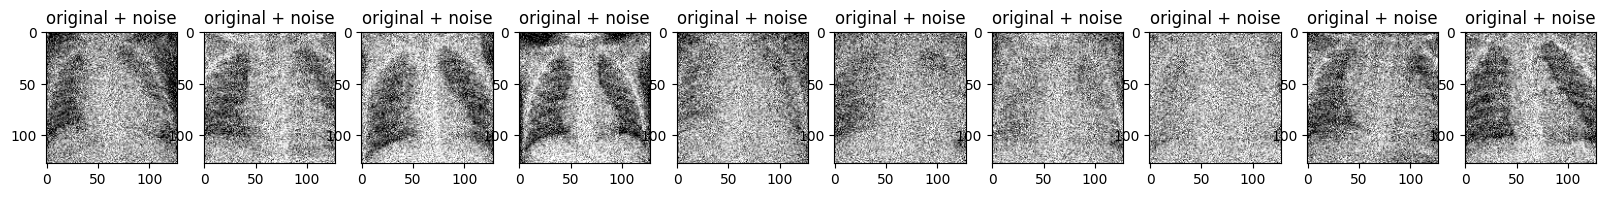

In [222]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [223]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers

# Encoder

n = 128
chan = 1
input_img = Input(shape=(n, n, chan))

l1 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
#l3 = Dropout(0.3)(l3)
l4 = Conv2D(64, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
#l3 = Dropout(0.5)(l3)
l7 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)
encoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_67 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_68 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_70 (Conv2D)          (None, 64, 64, 64)        36928     
                                                          

In [224]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers

# Encoder

n = 128
chan = 1
input_img = Input(shape=(n, n, chan))

l1 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
#l3 = Dropout(0.3)(l3)
l4 = Conv2D(64, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
#l3 = Dropout(0.5)(l3)
l7 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)
encoder.summary()

# Decoder

l8 = UpSampling2D()(l6)

l9 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),)(l8)
l10 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
#l3 = Dropout(0.3)(l3)
l13 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder = Model(input_img, decoded)
# You'll understand later what this is

autoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_72 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_73 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_74 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_75 (Conv2D)          (None, 64, 64, 64)        36928     
                                                          

In [225]:
autoencoder.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 128, 128, 32)         320       ['input_9[0][0]']             
                                                                                                  
 conv2d_73 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_72[0][0]']           
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 32)           0         ['conv2d_73[0][0]']           
 ng2D)                                                                                     

tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
best_model = tuner.get_best_models()[0]

In [226]:
autoencoder.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=losses.MeanSquaredError())
autoencoder.fit(x_train_noisy, x_train,epochs=25,batch_size = 16,shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/25
295/295 [==============================] - 40s 130ms/step - loss: 0.1149 - val_loss: 0.0023
Epoch 2/25
295/295 [==============================] - 38s 130ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 3/25
295/295 [==============================] - 37s 125ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/25
295/295 [==============================] - 37s 127ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/25
295/295 [==============================] - 37s 126ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/25
295/295 [==============================] - 37s 125ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/25
295/295 [==============================] - 37s 127ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/25
295/295 [==============================] - 37s 126ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/25
295/295 [==============================] - 37s 124ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/25
295/295 [==============================] - 37s 126ms/step - l

In [227]:
ori_weights = autoencoder.get_weights()

/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_8778/3380963639.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(x_val[1])


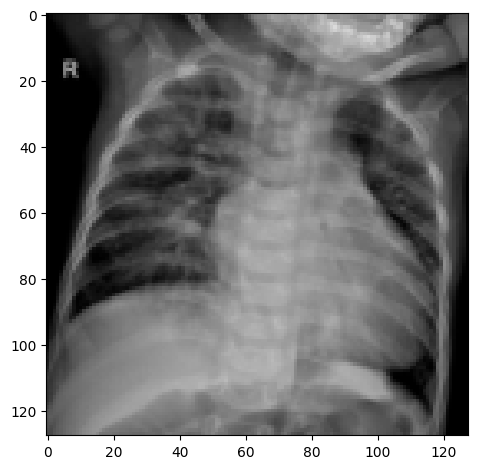

In [228]:
imshow(x_val[1])

In [229]:
decoded_imgs=autoencoder.predict(x_val_noisy)

17/17 [==============================] - 1s 65ms/step


/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_8778/79628611.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(decoded_imgs[1])


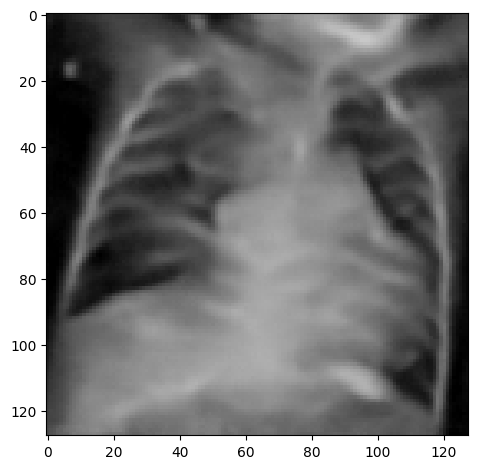

In [230]:
imshow(decoded_imgs[1])

In [231]:
# encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [232]:
def mse(orig, res):
    return ((orig - res) ** 2).mean()
     

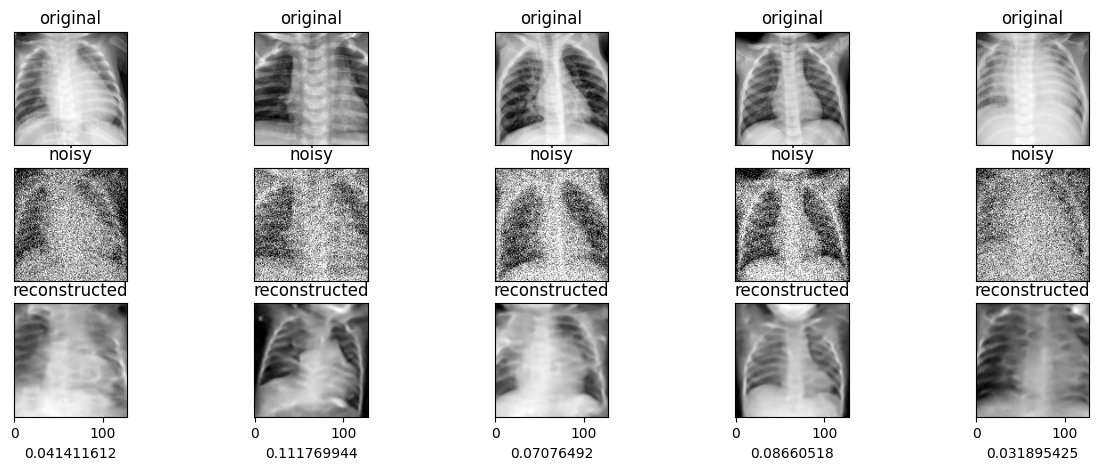

In [233]:
import matplotlib.pyplot as plt



n = 5
plt.figure(figsize=(15, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(True)
    plt.xlabel(mse(x_test[i], decoded_imgs[i]))
    ax.get_yaxis().set_visible(False)

plt.show()

/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_8778/2126481622.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(decoded_imgs[2])


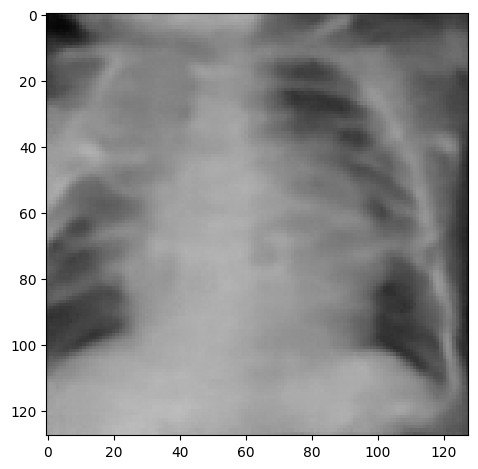

In [234]:
imshow(decoded_imgs[2])

# multiple "networks"

1) 50/50 netværk 
2) 4* 25 netværk
3) 10 * 10 netværk

planen er at træne det her netværk seperat og bruge noget magic til at sætte vægtene sammen til et netværk og så evaluerer dem mod det fulde netværk 

Vi kører alle netværk ved 25 epoker. 

In [235]:
len(x_val)

524

In [255]:
len(x_train)

x_train_noisy_501 = x_train_noisy[:4708//2]
x_testnoisy_501 = x_test_noisy[:624//2]
x_train_501 = x_train[:4708//2]
x_test_501 = x_test[:624//2]
x_val_noisy501 = x_val_noisy[:524//2]

x_train_noisy_502 = x_train_noisy[4708//2:4708]
x_train_502 = x_train[2354:4708]
x_test_noisy_502 = x_test_noisy[624//2:624]
x_test_502 = x_test[624//2:624]
x_val_502 = x_val_noisy[524//2:524]

len(x_train_502)

2354

# 50.1

In [256]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers

# Encoder

n = 128
chan = 1
input_img = Input(shape=(n, n, chan))

l1 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
#l3 = Dropout(0.3)(l3)
l4 = Conv2D(64, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
#l3 = Dropout(0.5)(l3)
l7 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)
encoder.summary()

# Decoder

l8 = UpSampling2D()(l6)

l9 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),)(l8)
l10 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
#l3 = Dropout(0.3)(l3)
l13 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder501 = Model(input_img, decoded)
# You'll understand later what this is

autoencoder501.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_102 (Conv2D)         (None, 128, 128, 32)      320       
                                                                 
 conv2d_103 (Conv2D)         (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_104 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_105 (Conv2D)         (None, 64, 64, 64)        36928     
                                                          

In [257]:
autoencoder501.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=losses.MeanSquaredError())
autoencoder501.fit(x_train_noisy_501, x_train_501,epochs=50,batch_size = 8,shuffle=True, validation_data=(x_testnoisy_501, x_test_501))
weights_501 = autoencoder501.get_weights() 

Epoch 1/50
295/295 [==============================] - 29s 94ms/step - loss: 0.0276 - val_loss: 0.0029
Epoch 2/50
295/295 [==============================] - 27s 90ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/50
295/295 [==============================] - 27s 90ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/50
295/295 [==============================] - 27s 93ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/50
295/295 [==============================] - 27s 90ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/50
295/295 [==============================] - 26s 89ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/50
295/295 [==============================] - 26s 89ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
295/295 [==============================] - 26s 89ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/50
295/295 [==============================] - 28s 96ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/50
295/295 [==============================] - 27s 93ms/step - loss: 0.001

In [258]:
decoded_imgs=autoencoder.predict(x_val_noisy501)

9/9 [==============================] - 1s 62ms/step


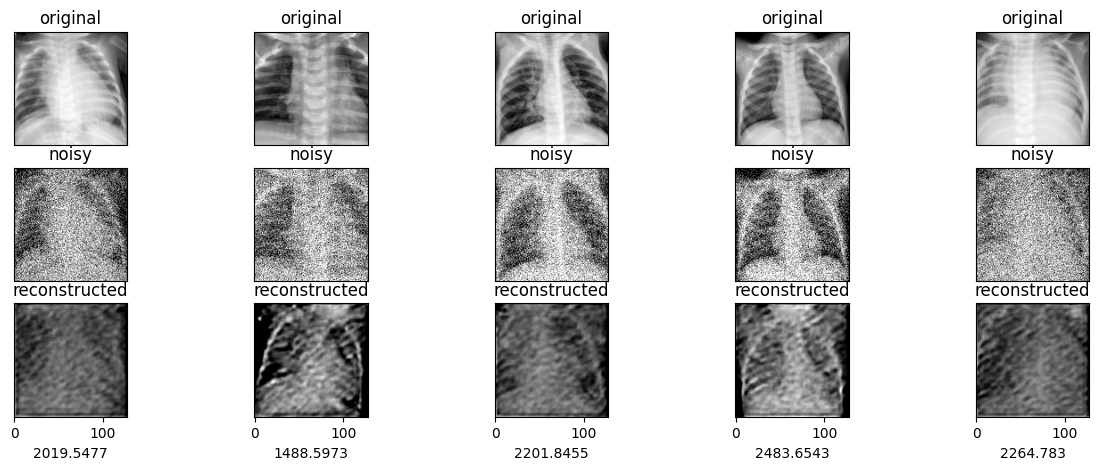

In [259]:
import matplotlib.pyplot as plt



n = 5
plt.figure(figsize=(15, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_501[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_testnoisy_501[i])
    plt.title("noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(True)
    plt.xlabel(mse(x_test_501[i], decoded_imgs[i]))
    ax.get_yaxis().set_visible(False)

plt.show()

In [260]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers

# Encoder

n = 128
chan = 1
input_img = Input(shape=(n, n, chan))

l1 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
#l3 = Dropout(0.3)(l3)
l4 = Conv2D(64, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
#l3 = Dropout(0.5)(l3)
l7 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)
encoder.summary()

# Decoder

l8 = UpSampling2D()(l6)

l9 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),)(l8)
l10 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
#l3 = Dropout(0.3)(l3)
l13 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder502 = Model(input_img, decoded)
# You'll understand later what this is

autoencoder502.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_112 (Conv2D)         (None, 128, 128, 32)      320       
                                                                 
 conv2d_113 (Conv2D)         (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_114 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_115 (Conv2D)         (None, 64, 64, 64)        36928     
                                                          

In [261]:
autoencoder502.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=losses.MeanSquaredError())
autoencoder502.fit(x_train_noisy_502, x_train_502,epochs=50,batch_size = 8,shuffle=True, validation_data=(x_test_noisy_502, x_test_502))
weights_502 = autoencoder502.get_weights()

Epoch 1/50
295/295 [==============================] - 29s 93ms/step - loss: 0.0105 - val_loss: 0.0023
Epoch 2/50
295/295 [==============================] - 27s 90ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/50
295/295 [==============================] - 26s 88ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/50
295/295 [==============================] - 26s 88ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/50
295/295 [==============================] - 26s 89ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/50
295/295 [==============================] - 26s 89ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/50
295/295 [==============================] - 26s 89ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
295/295 [==============================] - 26s 88ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/50
295/295 [==============================] - 28s 93ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/50
295/295 [==============================] - 27s 92ms/step - loss: 0.001

In [262]:
# Ensure that the arrays have the same shape
same_shape = all(w1.shape == w2.shape for w1, w2 in zip(weights_501, weights_502))
print(same_shape)

True


In [263]:
autoencoder501.evaluate(x_val)

17/17 [==============================] - 2s 68ms/step - loss: 7.4196e-05


7.419588655466214e-05

17/17 [==============================] - 1s 52ms/step


/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_8778/1948659756.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(de[0])


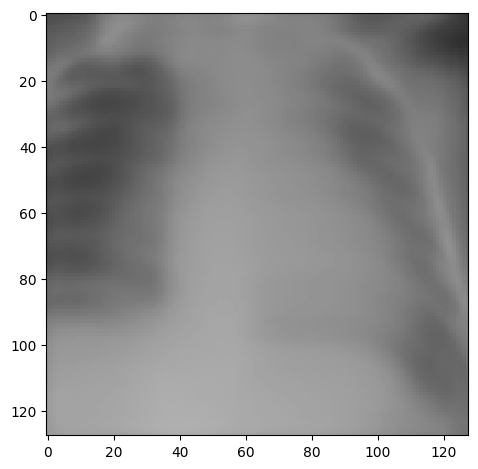

In [264]:
de = autoencoder501.predict(x_val)
imshow(de[0])

In [265]:
autoencoder.evaluate(x_val)

17/17 [==============================] - 1s 57ms/step - loss: 0.0034


0.003394241211935878

In [266]:
weights50501 = [ori - w1 for ori, w1 in zip(ori_weights, weights_501)]
weights50502 = [ori - w2 for ori, w2 in zip(ori_weights, weights_502)]
weights5050 = [(w1 +w2)/2 + ori for w1, w2,ori in zip(weights50501, weights50502, ori_weights)]
autoencoder.set_weights(weights5050)

17/17 [==============================] - 1s 62ms/step


/var/folders/d5/qsvd0xbs3610vyxc_s5y8cv80000gn/T/ipykernel_8778/4182645948.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(decoded_imgs[3])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


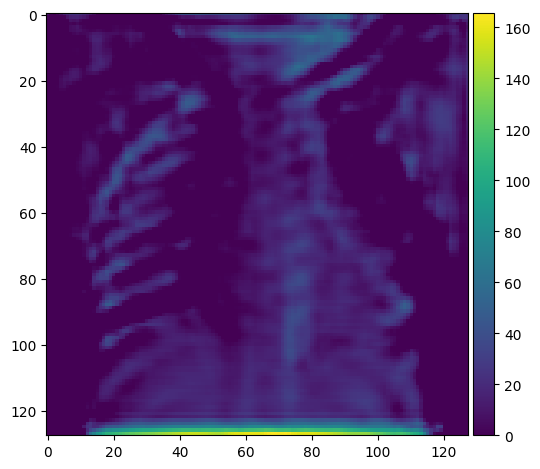

In [268]:
decoded_imgs = autoencoder.predict(x_val)
imshow(decoded_imgs[3])

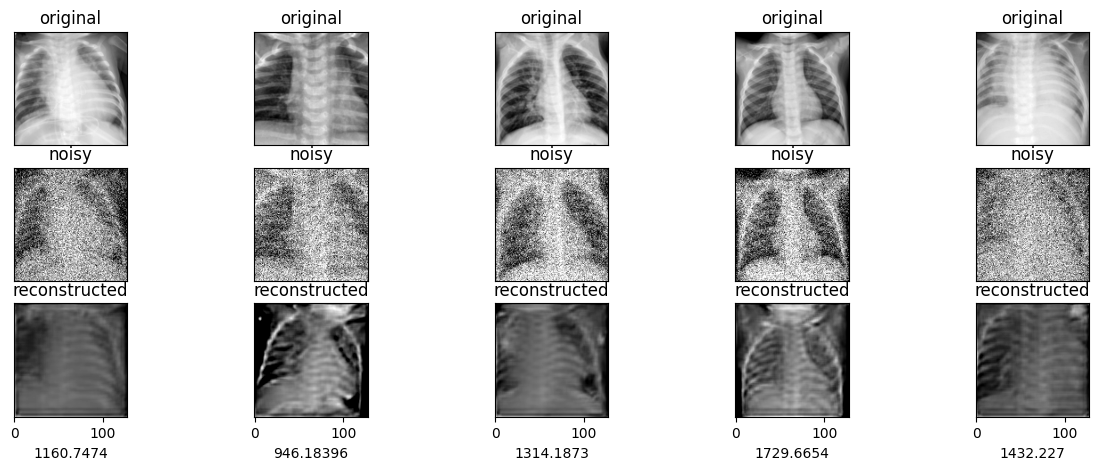

In [252]:
import matplotlib.pyplot as plt



n = 5
plt.figure(figsize=(15, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(True)
    plt.xlabel(mse(x_test[i], decoded_imgs[i]))
    ax.get_yaxis().set_visible(False)

plt.show()